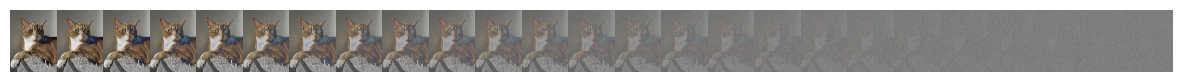

In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class Diffusion:
    def __init__(self, noise_steps=5, beta_start=0.0001, beta_end=0.02, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.beta = self.schedule_noise().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def schedule_noise(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def noise_image(self, image, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])

        epsilon = torch.randn_like(image)

        noisy_image = sqrt_alpha_hat * image + sqrt_one_minus_alpha_hat * epsilon
        return noisy_image

def apply_diffusion_to_image(image_path, diffusion_steps, beta_start, beta_end):
    # Load and convert image to tensor
    img = Image.open(image_path).convert("RGB")
    img_tensor = torch.tensor(np.array(img)).float() / 255.0
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)  # Shape: [1, C, H, W]

    # Initialize the diffusion process
    diffusion = Diffusion(
        noise_steps=diffusion_steps,
        beta_start=beta_start,
        beta_end=beta_end,
        device="cpu"  # Change to "cuda" if using GPU
    )

    # Apply noise to the image
    noisy_imgs = []
    for t in range(diffusion_steps):
        # Calculate the noise for this timestep
        noisy_img = diffusion.noise_image(img_tensor, torch.tensor([t]))
        noisy_imgs.append(noisy_img.squeeze(0).permute(1, 2, 0).numpy())  # Remove batch dim and permute to HWC for visualization

    # Convert the list of noisy images into a single concatenated image for visualization
    concat_img = np.concatenate(noisy_imgs, axis=1)
    concat_img = (concat_img * 255).astype(np.uint8)

    # Display the concatenated noisy images
    plt.figure(figsize=(15, 15))
    plt.imshow(concat_img)
    plt.axis('off')  # Hide the axes
    plt.show()


# Test the diffusion on an example image
apply_diffusion_to_image("./IMG_9494.jpg", diffusion_steps=25, beta_start=0.0001, beta_end=0.02)
